In [1]:
import torch
import numpy as np
import torch.nn as nn
import math
import pandas as pd
from psmiles import PolymerSmiles as PS
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer, TransformerEncoder, TransformerEncoderLayer
from torch.nn import MSELoss
from torch.nn import HuberLoss
from torch.optim import AdamW
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

log_transformer = FunctionTransformer(np.log1p, validate=True)
log_minmax_pipeline = Pipeline(steps=[
    ('log', log_transformer),
    ('minmax', MinMaxScaler())
])
from tqdm.auto import tqdm

mm = MinMaxScaler()
log_minmax_pipeline2 = Pipeline(steps=[
    ('log', log_transformer),
    ('minmax', MinMaxScaler())
])

ModuleNotFoundError: No module named 'torch'

In [13]:
class PolymerDataset(Dataset):
    def __init__(self, csv_path, mm, log_minmax):
        """
        csv_path: SMILES와 속성(dp, cond)이 담긴 CSV 경로
        mm: sklearn MinMaxScaler (dp에 사용)
        log_minmax: sklearn MinMaxScaler (cond에 사용)
        """
        df = pd.read_csv(csv_path)
        # ── 1) dp / cond 스케일링 → [N,1]
        dp_vals = df.iloc[:, 4].values.reshape(-1,1)
        cond_vals = df.iloc[:, 6].values.reshape(-1,1)

        self.dp = torch.tensor(mm.fit_transform(dp_vals),   dtype=torch.float32).unsqueeze(-1)
        self.cond = torch.tensor(log_minmax.fit_transform(cond_vals), dtype=torch.float32).unsqueeze(-1)

        # ── 2) SMILES 전처리 → One-hot 시퀀스
        raw_smiles = df.iloc[:,1].tolist()
        self.vocab = list("CHNOPSFIBrClc()[]=#@*+-1234567890") + ["_"]
        self.c2i   = {c:i for i,c in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        self.max_len    = max(len(s) for s in raw_smiles)

        self.sequences = []
        for s in raw_smiles:
            idxs = self._smiles_to_idx(s)
            oh   = F.one_hot(idxs, num_classes=self.vocab_size).float()
            self.sequences.append(oh)

    def _smiles_to_idx(self, s: str):
        arr = torch.full((self.max_len,), self.c2i["_"], dtype=torch.long)
        for i, ch in enumerate(s):
            arr[i] = self.c2i.get(ch, self.c2i["_"])
        return arr

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # seq_onehot: [max_len, vocab_size], dec: [2,1]
        return self.sequences[idx], self.dp[idx], self.cond[idx]

In [14]:
Polymers = "simulation-trajectory-aggregate_aligned.csv"
dataset = PolymerDataset(Polymers, mm, log_minmax_pipeline)

train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=False)


In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float()
                        * (-math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(pos * div)
        pe[:,1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0).transpose(0,1)  # [max_len,1,d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        x = x + self.pe[:x.size(1)].permute(1,0,2)
        return self.dropout(x)



class TF(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=256,
        n_heads=4,
        d_ff=1024,
        enc_seq_len=5000,
        cond_seq_len=2,  # dp+cond 두 스텝
        dropout=0.2
    ):
        super().__init__()
        # ── Encoder (SMILES) ───────────────────────────────────
        self.smiles_emb = nn.Linear(vocab_size, d_model)
        self.pe_smiles  = PositionalEncoding(d_model, dropout, max_len=enc_seq_len)
        enc_layer = TransformerEncoderLayer(
            batch_first=True,
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation="gelu"
        )
        self.encoder = TransformerEncoder(enc_layer, num_layers=2)

        # ── Decoder (properties) ───────────────────────────────
        self.prop_emb = nn.Linear(1, d_model)
        self.pe_prop  = PositionalEncoding(d_model, dropout, max_len=cond_seq_len)
        dec_layer = TransformerDecoderLayer(
            batch_first=True,
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation="gelu"
        )
        self.decoder = TransformerDecoder(dec_layer, num_layers=2)

        # ── Output head ────────────────────────────────────────
        self.predict = nn.Linear(d_model, 1)

    def forward(self, seq_onehot: torch.Tensor, properties: torch.Tensor):
        """
        seq_onehot: [B, S, vocab_size]
        properties: [B, T, 1]   (T ≤ cond_seq_len)
        """
        # Encoder
        x = self.smiles_emb(seq_onehot)         # [B, S, d_model]
        x = self.pe_smiles(x)
        enc = self.encoder(x)                   # [B, S, d_model]

        # Decoder input
        tgt = self.prop_emb(properties)         # [B, T, d_model]
        tgt = self.pe_prop(tgt)

        # Decoder + predict
        dec_out = self.decoder(tgt, enc)
        out = self.predict(dec_out)             # [B, T, 1]
        return out

In [16]:
model = TF(d_model = 256, vocab_size=dataset.vocab_size)
model.cuda()

lr = 3e-5
optim = AdamW(model.parameters(), lr=lr)
loss_fn = HuberLoss()

In [ ]:
epoch = 1200
model.train()
progress = tqdm(range(epoch), desc="Training")
loss_arr = list()
real = list()
predict = list()
for i in progress:
    batchloss = 0.0
    for (smiles_enc, dec_in, dec_out) in train_dataloader:
        optim.zero_grad()

        smiles_enc = smiles_enc.to(device)
        dec_in = dec_in.to(device)
        dec_out = dec_out.to(device)

        output = model(smiles_enc, dec_in)

        loss = loss_fn.forward(output.float(), dec_out)
        loss.backward()
        optim.step()

        batchloss += loss
    loss_arr.append((batchloss.cpu().item() / len(train_dataloader)))
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader))) # 여기는 그냥 에러 구하는 거

Training:   0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
class PolymerDataset_test(Dataset):
    def __init__(self, csv_path):
        """
        csv_path: SMILES와 속성(dp, cond)이 담긴 CSV 파일 경로
        log_minmax_pipeline: cond 컬럼 스케일링에 사용할 sklearn 파이프라인
        """
        # 1) CSV 읽기
        df = pd.read_csv(csv_path)
        
        # 3) SMILES 전처리: vocab, 인덱스 맵, 시퀀스 최대 길이
        raw_smiles = df.iloc[:, 1].tolist()
        self.vocab = list("CHNOPSFIBrClc()[]=#@*+-1234567890") + ["_"]
        self.c2i = {c: i for i, c in enumerate(self.vocab)}
        self.vdim = len(self.vocab)
        # +1 자리는 EOS 혹은 패딩용
        self.max_len = max(len(s) for s in raw_smiles)
        
        self.vocab_size = len(self.vocab)
        # 4) 모든 SMILES를 one-hot 시퀀스로 미리 변환해 놓기
        self.sequences = []
        for s in raw_smiles:
            idxs = self._smiles_to_idx(s)
            oh = F.one_hot(idxs, num_classes=self.vdim).float()
            self.sequences.append(oh)
    
    def _smiles_to_idx(self, s: str) -> torch.Tensor:
        """SMILES 문자열을 정수 인덱스 시퀀스로 변환 (패딩 포함)"""
        arr = torch.full((self.max_len,), self.c2i["_"], dtype=torch.long)
        for i, ch in enumerate(s):
            arr[i] = self.c2i.get(ch, self.c2i["_"])
        return arr

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Returns:
            seq_onehot: FloatTensor [max_len, vdim]
            dp: LongTensor [ ]
            cond: FloatTensor [ ]
        """
        return self.sequences[idx]

In [ ]:
test_data = PolymerDataset_test("gen.csv")

test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, drop_last=False)

In [ ]:
model.eval()
all=[]

with torch.no_grad():
    for seq_onehot in test_dataloader:
        # seq_onehot: [B, S, V], dec: [B, 2, 1] (dp, cond)
        seq_onehot = seq_onehot.to(device)
        dp_true    = torch.full([seq_onehot.size(0)],0.1,dtype=torch.float32).to(device).unsqueeze(-1).unsqueeze(-1)  # shape [B]
        print(dp_true.shape)

        out = model(seq_onehot, dp_true)
        all.append(out)
all = torch.cat(all, dim=0)

torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([230, 1, 1])


In [ ]:
cond = all.detach().cpu().numpy()
max(cond)
cond_rev = log_minmax_pipeline.inverse_transform(cond.reshape(-1, 1))
print(format(max(cond_rev)[0],"e"))

1.366346e-03


In [ ]:
df = pd.read_csv("gen.csv")

# ② 0이 들어 있는 행 인덱스 목록
zero_rows = df.index[df["CONDUCTIVITY"] == 0].tolist()
if not zero_rows:
    raise ValueError("CONDUCTIVITY가 0인 행이 없습니다.")

# ③ 덮어쓸 시작 위치 = 첫 번째 0
start = zero_rows[0]

# ④ 덮어쓸 길이 체크
conds_flat = np.asarray(cond_rev).flatten()
n_new = len(conds_flat)

# CSV 끝을 넘어가면 오류
if start + n_new > len(df):
    raise ValueError(f"데이터 길이 부족: 0부터 {n_new}개 넣으려면 "
                     f"CSV에 최소 {start + n_new}행이 있어야 합니다.")

# ⑤ 실제로 덮어쓰기
df.loc[start:start + n_new - 1, "CONDUCTIVITY"] = conds_flat

# ⑥ 저장
df.to_csv("gen.csv", index=False)
print(f"[✓] {n_new}개의 CONDUCTIVITY 값을 행 {start}~{start+n_new-1}에 덮어썼습니다.")

[✓] 742개의 CONDUCTIVITY 값을 행 0~741에 덮어썼습니다.


/tmp/ipykernel_202629/1237117571.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.58030336e-04 1.54184978e-04 1.07981940e-03 1.27358086e-04
 1.13754300e-04 1.31085911e-03 1.05433501e-04 1.30443985e-03
 1.34425442e-04 1.21810439e-03 1.96217865e-04 9.00662213e-04
 8.08146549e-04 1.05411935e-04 1.33095251e-03 1.33061281e-03
 2.42847847e-04 1.23921374e-03 1.38197807e-04 1.23761152e-03
 1.51860688e-04 1.81177355e-04 9.09898954e-04 1.21559016e-03
 4.61686432e-04 3.08180199e-04 1.32498716e-03 4.63795936e-04
 1.68627987e-04 1.28186832e-03 1.09914632e-03 1.20576282e-04
 1.23796286e-03 5.61953857e-05 2.07874211e-04 1.83248412e-04
 1.31048332e-03 2.19194146e-04 9.05062538e-04 1.89133774e-04
 2.94466154e-04 1.26854400e-03 1.23337115e-04 5.90032578e-05
 1.32637750e-03 1.56679831e-04 1.27399713e-03 1.10114668e-03
 7.68791942e-05 1.10339583e-03 9.38253579e-05 1.13046216e-03
 1.17602765e-04 1.46281876e-04 9.40323589e-05 1.5

[*][N][*]


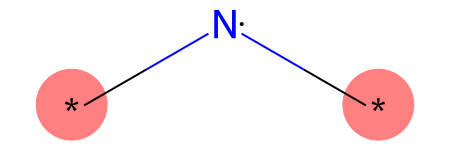

In [ ]:
PS("*[N+]*")